In [1]:
import scanpy as sc
import pandas as pd
import os

# Data Exploration: RxRx1, HUVEC

* [I. Data](#data)
    * [A. What is HUVEC?](#data_sub1)
    * [B. How were the experiments structured?](#data_sub2)
* [II. Visualization](#vis)
    * [A. Read in the data](#vis_sub1)
    * [B. Looking into different batch effects](#vis_sub2)
        * [1. Does the data cluster by siRNA or is the technical effect overall stronger?](#vis_batch0)
        * [2. Within plate (intra-plate) effects](#vis_batch1)
        * [3. In-between plate (inter-plate) effects](#vis_batch2)
        * [4. In-between experiment effects](#vis_batch3)

## I. Data  <a class="anchor" id="data"></a>

<u>*A.  What is HUVEC?*</u> <a class="anchor" id="data_sub1"></a><br>
HUVEC (human umbilical vein endothelial cells) is a cell line that is derived from the endothelium of the human umbilical vein. These cells are often used in vascular research and drug discovery.

*<u>B.  How were the experiments structured?*</u> <a class="anchor" id="data_sub2"></a> <br>
In each experiment, there are: 
- 1 untreated well (negative control)
- 30 wells treated with control siRNAs (positive control, 30 different siRNAs that are the same across each plate and each experiment)
- 277 wells treated with different siRNAs (treatment)
<br>

In total, **24 experiments** were conducted on the cell line HUVEC. For more information please see: https://www.rxrx.ai/rxrx1 and https://github.com/theislab/batch_correction_cellpainting/blob/feat/rxrx1_huvec_exploration/data/rxrx1/rxrx1_overview.md <br>

**Only using positive and negative controls further.** 

## II. Visualization <a class="anchor" id="vis"></a>

### A. Read in the data <a class="anchor" id="vis_sub1"></a>

Read in the embeddings and add metadata to adata.obs + add well row & column to the metadata:

In [2]:
meta_file = "data/rxrx1/metadata.csv"
embedding_file = "data/rxrx1/embeddings.csv"
if not os.path.exists(meta_file):
    raise FileNotFoundError("Please download the metadata from https://www.rxrx.ai/rxrx1 and put the file metadata.csv in the directory data/rxrx1")
if not os.path.exists(embedding_file):
    raise FileNotFoundError("Please download the embeddings from https://www.rxrx.ai/rxrx1 and put the file embeddings.csv in the directory data/rxrx1")

In [3]:
adata = sc.read_csv(embedding_file)
meta = pd.read_csv(meta_file, index_col = 0)
# change the order of the rows in the meta data to match the order in the embeddings
meta = meta.reindex(pd.read_csv(embedding_file, index_col = 0).index)
adata.obs = meta
adata.obs['well_row'], adata.obs['well_column'] = adata.obs['well'].str[:1], adata.obs['well'].str[1:]
print(adata)
meta.head(n=3)

AnnData object with n_obs × n_vars = 125510 × 128
    obs: 'well_id', 'cell_type', 'dataset', 'experiment', 'plate', 'well', 'site', 'well_type', 'sirna', 'sirna_id', 'well_row', 'well_column'


,well_id,cell_type,dataset,experiment,plate,well,site,well_type,sirna,sirna_id,well_row,well_column
site_id,,,,,,,,,,,,
U2OS-01_1_B02_1,U2OS-01_1_B02,U2OS,train,U2OS-01,1,B02,1,negative_control,EMPTY,1138,B,02
U2OS-01_1_B02_2,U2OS-01_1_B02,U2OS,train,U2OS-01,1,B02,2,negative_control,EMPTY,1138,B,02
U2OS-01_1_B03_1,U2OS-01_1_B03,U2OS,train,U2OS-01,1,B03,1,treatment,s19651,267,B,03


Subset anndata on HUVEC and the positive and negative controls:

In [4]:
huvec = adata[adata.obs["cell_type"] == "HUVEC"]
huvec = huvec[huvec.obs["well_type"].isin(["negative_control", "positive_control"])]
huvec

View of AnnData object with n_obs × n_vars = 5982 × 128
    obs: 'well_id', 'cell_type', 'dataset', 'experiment', 'plate', 'well', 'site', 'well_type', 'sirna', 'sirna_id', 'well_row', 'well_column'

Save anndata: 

In [12]:
huvec.write_h5ad(
    "rxrx1_huvec.h5ad",
    compression="gzip"
)

### B. Looking into different batch effects: <a class="anchor" id="vis_sub2"></a>

<font size="3"> **1. Does the data cluster by siRNA or is the technical effect overall stronger?** </font> <a class="anchor" id="vis_batch0"></a>

Does the data cluster by siRNA? Do the negative controls separate from the positives? 
    
    -> Plot positive and negative controls together & color by siRNA 

/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


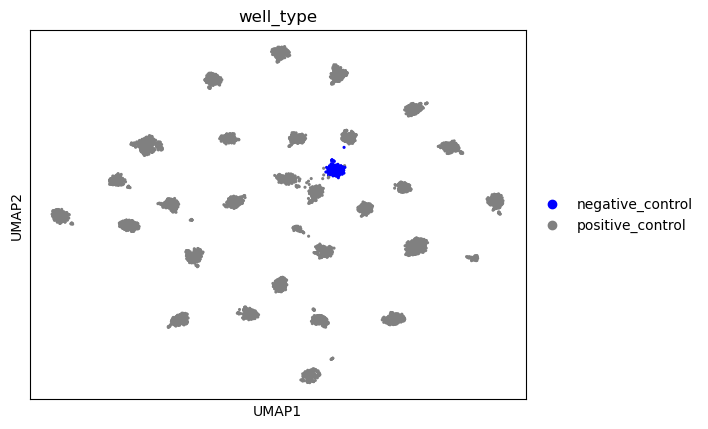

/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


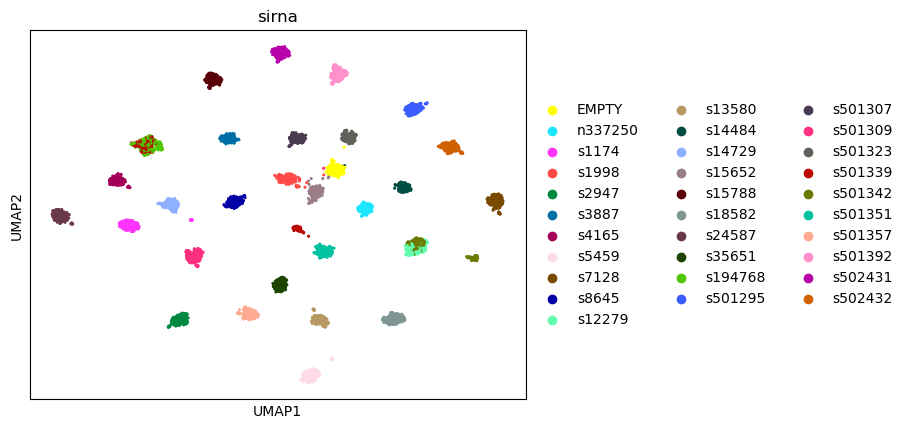

In [9]:
sc.pp.neighbors(huvec, n_neighbors=15, use_rep = "X")
sc.tl.umap(huvec)
sc.pl.umap(huvec, color="well_type", palette={"positive_control": "grey", "treatment": "grey", "negative_control": "blue"})
sc.pl.umap(huvec, color= "sirna")

Negative controls separate nicely from the positive controls, forming an own cluster. The positive controls also cluster by siRNA. In two clusters, two different siRNAs are mixed. 

Anndata objects for the two control groups for later visualization purposes: 

In [5]:
pos_controls = huvec[huvec.obs["well_type"] == "positive_control"]
sc.pp.neighbors(pos_controls, n_neighbors=15, use_rep = "X")
sc.tl.umap(pos_controls)
neg_controls = huvec[huvec.obs["well_type"] == "negative_control"]
sc.pp.neighbors(neg_controls, n_neighbors=15, use_rep = "X")
sc.tl.umap(neg_controls)

<font size="3"> **2. Within plate (intra-plate) effects** </font> <a class="anchor" id="vis_batch1"></a>


Do the images cluster by well row/column, i.e. well assignment? <br>
We can already see above that the images cluster by siRNA.

    -> For the positive controls: visualize the images of one siRNA across all experiments & color by well position (the positive control siRNAs are in the same wells in one experiment but in different ones across experiments)
    -> Color negative control across experiments by well assignment

/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


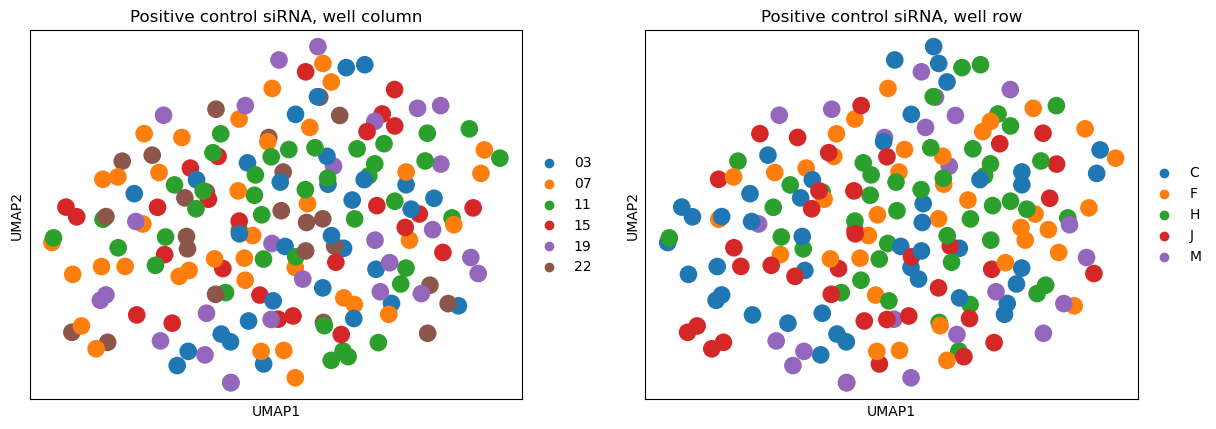

/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


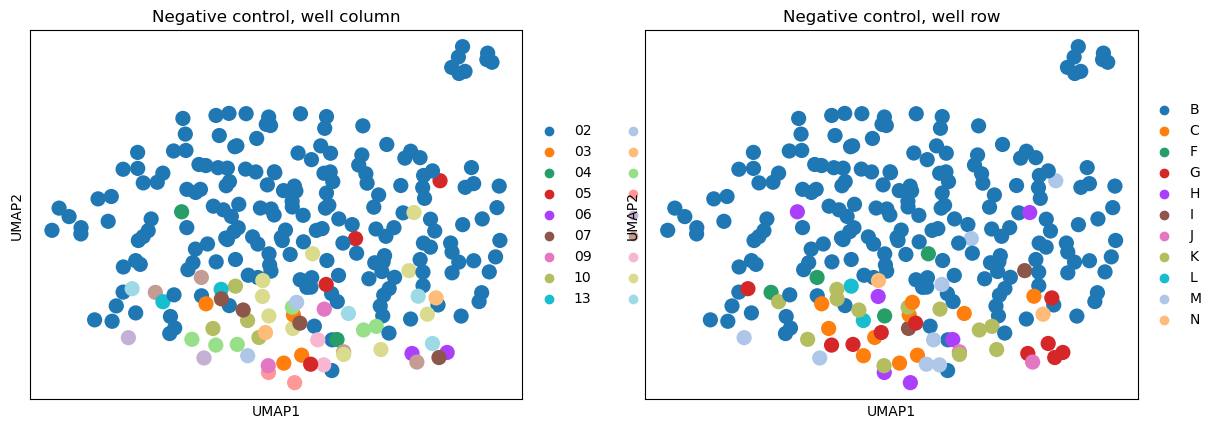

/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


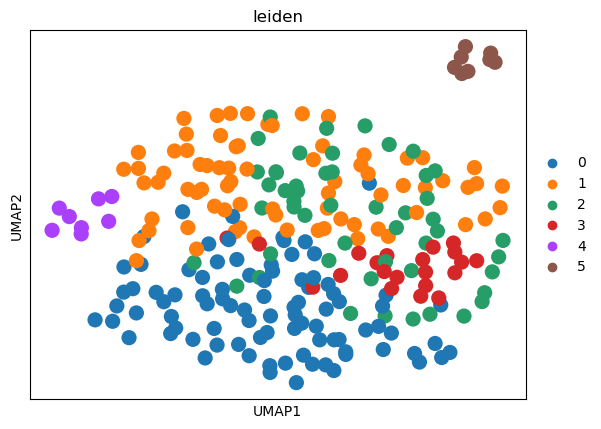

In [9]:
#positive control 
poscontrols_sirna = pos_controls[pos_controls.obs["sirna"] == "s3887"]
sc.pp.neighbors(poscontrols_sirna, n_neighbors=15, use_rep = "X")
sc.tl.umap(poscontrols_sirna)
sc.pl.umap(poscontrols_sirna, color=["well_column", "well_row"], title = ["Positive control siRNA, well column", "Positive control siRNA, well row"])
#negative control
sc.pl.umap(neg_controls, color=["well_column", "well_row"], title = ["Negative control, well column", "Negative control, well row"])
sc.tl.leiden(neg_controls, resolution = 0.7)
sc.pl.umap(neg_controls, color=['leiden'])

Above we can see, that the images of siRNA s3887 do not cluster by well assignment. But in the negative controls, the images not in well B02 form a cluster, namely cluster 0 in the Leiden clustering. 

<font size="3"> **3. In-between plate (inter-plate) effects** </font> <a class="anchor" id="vis_batch2"></a>

Do the images (of one experiment) cluster by plate assignment? 
    
    -> Subset again one siRNA for the positive controls 
    -> Visualize the negative control and one positive control siRNA across the experiments & color by plate 

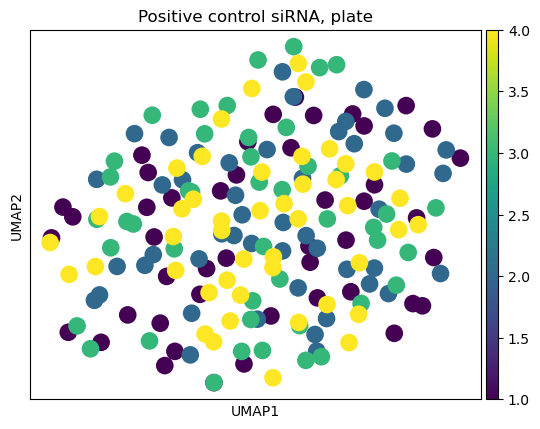

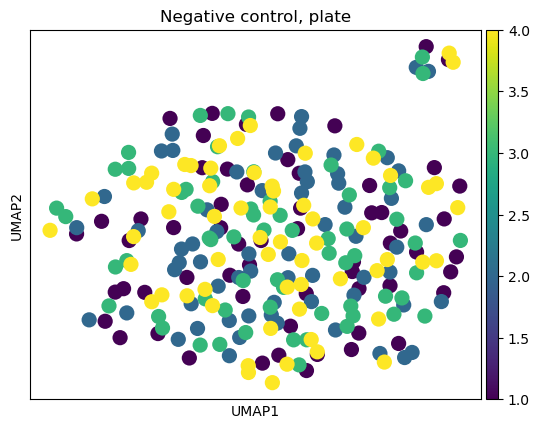

In [10]:
#positive control siRNA from above
sc.pl.umap(poscontrols_sirna, color=["plate"], title = "Positive control siRNA, plate")
#negative control 
sc.pl.umap(neg_controls, color=["plate"], title = "Negative control, plate")

Both, the positive control siRNA and the negative control do not seem to cluster by plate.

<font size="3"> **4. In-between experiment effects** </font> <a class="anchor" id="vis_batch3"></a>

Do the images cluster by experiment? 

    -> Visualize clustering across the experiments for both controls
    -> For the positive controls: subset one sirna und color by experiment 

/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


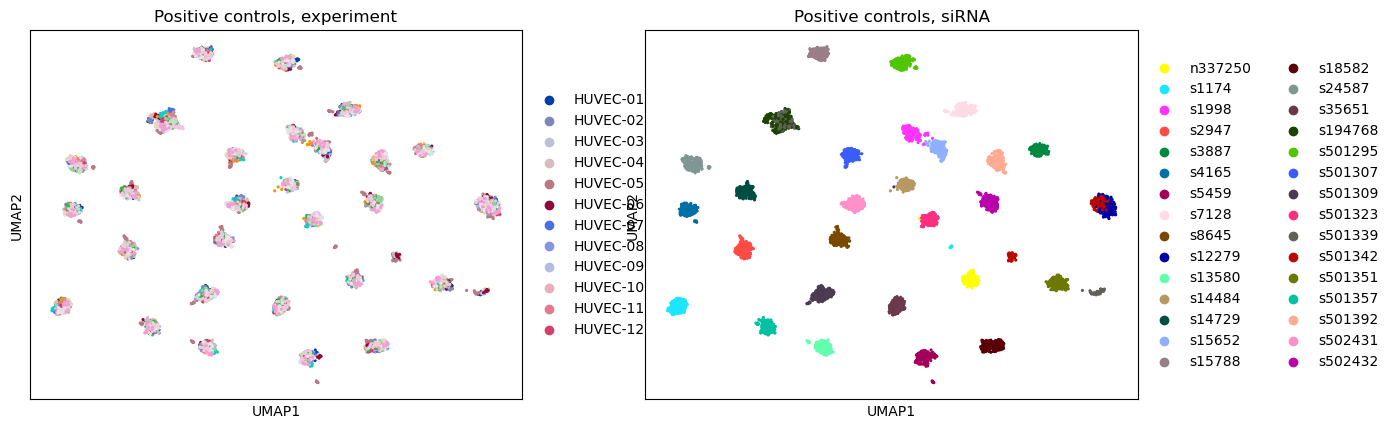

/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


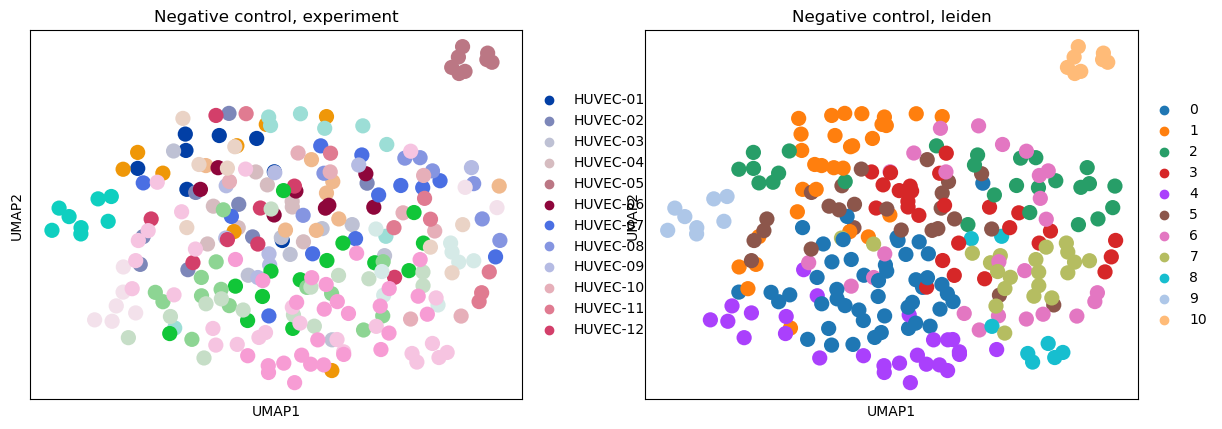

In [11]:
#positive controls: 
sc.pl.umap(pos_controls, color=["experiment", "sirna"], title = ["Positive controls, experiment", "Positive controls, siRNA"])
#negative control: 
sc.tl.leiden(neg_controls, resolution = 1.0)
sc.pl.umap(neg_controls, color=["experiment", "leiden"], title = ["Negative control, experiment", "Negative control, leiden"])

In the negative controls, there are two outlier experiments , HUVEC-19 and HUVEC-05, whose images have "their own" clusters in the Leiden clustering, namely cluster 9 and cluster 10. <br>
When looking at all positive controls together, the biology seems to be stronger than the experiment batch effect. To investigate that further, let's subset one positive control siRNA: 

/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


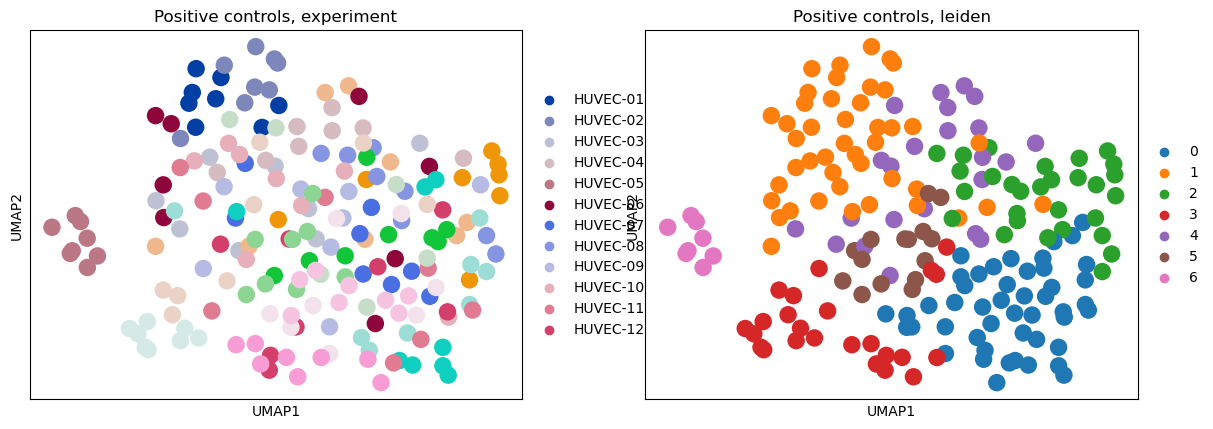

In [12]:
poscontrols_sirna = pos_controls[pos_controls.obs["sirna"] == "s501351"]
sc.pp.neighbors(poscontrols_sirna, n_neighbors=15, use_rep = "X")
sc.tl.umap(poscontrols_sirna)
sc.tl.leiden(poscontrols_sirna, resolution = 1.0)
sc.pl.umap(poscontrols_sirna, color=["experiment", "leiden"], title = ["Positive controls, experiment", "Positive controls, leiden"])

When looking at one siRNA and coloring by experiment, technical variations can be spotted. E.g., for the siRNA s501351 the 6th cluster of the Leiden clustering only consists of images of one experiment.